In [1]:
# Cell 1: Setup, Configuration, and Imports

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2 # OpenCV for image loading and processing

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as transforms # Using v2 for up-to-date transforms

# Configuration
CONFIG = {
    "DATASET_PATH": r"C:\college\_cutie\cv\model_train\dataset", # IMPORTANT: User needs to verify this path
    "IMAGE_DIR_NAME": "preprocessed_images", 
    "MASK_DIR_NAME": "masks",
    "CSV_NAME": "dataset.csv",
    "IMAGE_SIZE": (512, 512), 
    "BATCH_SIZE": 2, # << CHANGED: Reduced for debugging CUDNN error
    "NUM_CLASSES_SEG": 3, 
    "LEARNING_RATE": 1e-4, 
    "NUM_EPOCHS": 20, 
    "DEVICE": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "CHECKPOINT_DIR": "checkpoints_nir_unet", 
    "MULTITASK": True, 
    "NUM_REGRESSION_TARGETS": 2, 
    "PIN_MEMORY": True, 
    "NUM_WORKERS": 0, # Keep at 0 for local Windows debugging if issues persist
    "SEED": 42, 
    "RESUME_TRAINING": False, 
    "LATEST_CHECKPOINT_PATH": None, 
    "VALIDATION_SPLIT": 0.2, 
    "TEST_SPLIT": 0.1, 
}

# Create checkpoint directory if it doesn't exist
os.makedirs(CONFIG["CHECKPOINT_DIR"], exist_ok=True)

# Set random seeds for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(CONFIG["SEED"])

# --- CUDA / cuDNN Diagnostics ---
# Uncomment the line below to disable cuDNN if CUDNN_STATUS_INTERNAL_ERROR persists.
# This will make PyTorch use its native CUDA kernels, which can be slower but might avoid the error.
# torch.backends.cudnn.enabled = False
# print(f"cuDNN Enabled: {torch.backends.cudnn.enabled}")


print(f"Using device: {CONFIG['DEVICE']}")
print(f"PyTorch Version: {torch.__version__}")
if CONFIG["DEVICE"].type == 'cuda':
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"cuDNN Version: {torch.backends.cudnn.version()}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
print(f"Number of DataLoader workers: {CONFIG['NUM_WORKERS']}")


# Basic image transformations
data_transforms = {
    'image': transforms.Compose([
        transforms.ToImage(), 
        transforms.Resize(CONFIG["IMAGE_SIZE"], antialias=True),
        transforms.ToDtype(torch.float32, scale=True), 
        transforms.Normalize(mean=[0.5], std=[0.5]) 
    ]),
    'mask': transforms.Compose([
        transforms.ToImage(),
        transforms.Resize(CONFIG["IMAGE_SIZE"], interpolation=transforms.InterpolationMode.NEAREST, antialias=False), 
        transforms.ToDtype(torch.long, scale=False) 
    ])
}


Using device: cuda
PyTorch Version: 2.7.0+cu118
CUDA Version: 11.8
cuDNN Version: 90100
GPU Name: NVIDIA GeForce RTX 3060 Laptop GPU
Number of DataLoader workers: 0


In [2]:
# Cell 2: Custom Dataset Class

class NIRDataset(Dataset):
    def __init__(self, dataframe, base_path, image_dir, mask_dir, image_transform=None, mask_transform=None, multitask=False, image_size_for_coords=512):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame with image and mask paths and regression targets.
            base_path (str): Base directory of the dataset.
            image_dir (str): Directory name for images within base_path.
            mask_dir (str): Directory name for masks within base_path.
            image_transform (callable, optional): Optional transform to be applied on an image.
            mask_transform (callable, optional): Optional transform to be applied on a mask.
            multitask (bool): If True, also loads regression targets.
            image_size_for_coords (int): The image size used for normalizing coordinates.
        """
        self.dataframe = dataframe
        self.base_path = base_path
        self.image_dir = image_dir 
        self.mask_dir = mask_dir   
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.multitask = multitask
        self.image_size_for_coords = image_size_for_coords

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_rel_path = self.dataframe.iloc[idx]['preprocessed_image']
        mask_rel_path = self.dataframe.iloc[idx]['mask']
        
        img_name = os.path.join(self.base_path, img_rel_path)
        mask_name = os.path.join(self.base_path, mask_rel_path)

        try:
            image = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
            if image is None:
                raise FileNotFoundError(f"Image not found or corrupted: {img_name} (relative: {img_rel_path})")
            
            mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                raise FileNotFoundError(f"Mask not found or corrupted: {mask_name} (relative: {mask_rel_path})")
            
            mask[mask > CONFIG["NUM_CLASSES_SEG"] - 1] = 0 

        except Exception as e:
            print(f"Error loading data at index {idx} (Image: {img_name}, Mask: {mask_name}): {e}")
            dummy_image = torch.zeros((1, *CONFIG["IMAGE_SIZE"]), dtype=torch.float32) 
            dummy_mask = torch.zeros(CONFIG["IMAGE_SIZE"], dtype=torch.long) 
            if self.multitask:
                dummy_coords = torch.zeros(CONFIG["NUM_REGRESSION_TARGETS"], dtype=torch.float32)
                return dummy_image, dummy_mask, dummy_coords
            return dummy_image, dummy_mask

        if image.ndim == 2:
            image = image[:, :, np.newaxis] 
        if mask.ndim == 2:
            mask = mask[:, :, np.newaxis]   

        if self.image_transform:
            image = self.image_transform(image) 

        if self.mask_transform:
            mask = self.mask_transform(mask) 
            mask = mask.squeeze(0) 

        if self.multitask:
            acf_x_val = self.dataframe.iloc[idx]['acf_center_x']
            acf_y_val = self.dataframe.iloc[idx]['acf_center_y']

            # --- Robust handling for acf_center_x and acf_center_y ---
            # Ensure they are scalars before creating the tensor.
            # This handles cases where CSV might interpret numbers as lists/arrays.
            try:
                if isinstance(acf_x_val, (list, tuple, np.ndarray)):
                    if len(acf_x_val) > 0:
                        acf_x = float(acf_x_val[0]) # Take the first element if it's iterable
                    else: # Handle empty iterable case
                        print(f"Warning: Empty list/array for acf_center_x at index {idx}. Using 0.")
                        acf_x = 0.0
                else:
                    acf_x = float(acf_x_val)

                if isinstance(acf_y_val, (list, tuple, np.ndarray)):
                    if len(acf_y_val) > 0:
                        acf_y = float(acf_y_val[0]) # Take the first element
                    else: # Handle empty iterable case
                        print(f"Warning: Empty list/array for acf_center_y at index {idx}. Using 0.")
                        acf_y = 0.0
                else:
                    acf_y = float(acf_y_val)
            except Exception as coord_err:
                print(f"Error processing coordinates at index {idx} (X: {acf_x_val}, Y: {acf_y_val}): {coord_err}. Using (0,0).")
                acf_x, acf_y = 0.0, 0.0
            # -----------------------------------------------------------

            # Now acf_x and acf_y are Python floats
            coords_list = [acf_x / self.image_size_for_coords, 
                           acf_y / self.image_size_for_coords]
            coords = torch.tensor(coords_list, dtype=torch.float32) # This will be 1D, shape [2]
            
            return image, mask, coords
        else:
            return image, mask


Loaded dataset with 2016 samples.
Dataset columns: ['Unnamed: 0', 'person_id', 'age', 'complexion', 'genere', 'observation', 'nir_image', 'preprocessed_image', 'mask', 'acf_bbox_x1', 'acf_bbox_x2', 'acf_bbox_y1', 'acf_bbox_y2', 'acf_center_x', 'acf_center_y', 'arm_angle']
Training samples: 1410
Validation samples: 404
Test samples: 202

Visualizing a sample from the training set:


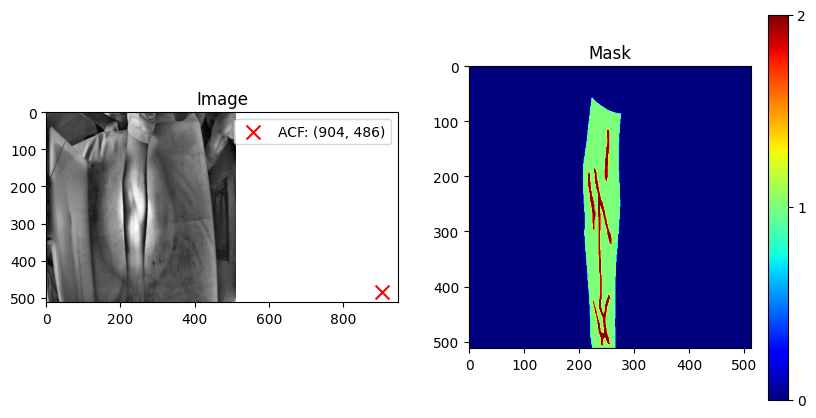

In [3]:
# Cell 3: Data Loading and Splitting

from sklearn.model_selection import train_test_split

# Load the dataset CSV
csv_path = os.path.join(CONFIG["DATASET_PATH"], CONFIG["CSV_NAME"])
try:
    full_df = pd.read_csv(csv_path)
except FileNotFoundError:
    print(f"Error: {CONFIG['CSV_NAME']} not found at {csv_path}. Please check the path and file name.")
    # Gracefully exit or raise an error if the CSV is critical
    # For now, we'll create a dummy df if it's not found, to allow notebook to run further,
    # but user should be alerted.
    if not os.path.exists(CONFIG["DATASET_PATH"]):
        print(f"Dataset path {CONFIG['DATASET_PATH']} does not exist.")
    full_df = pd.DataFrame() # Or raise SystemExit("Dataset CSV not found.")

if full_df.empty:
    print("DataFrame is empty. Cannot proceed with data loading.")
else:
    print(f"Loaded dataset with {len(full_df)} samples.")

    # Log columns to help user verify
    print("Dataset columns:", full_df.columns.tolist())
    
    # Check for necessary columns
    required_cols = ['preprocessed_image', 'mask']
    if CONFIG["MULTITASK"]:
        required_cols.extend(['acf_center_x', 'acf_center_y'])
    
    missing_cols = [col for col in required_cols if col not in full_df.columns]
    if missing_cols:
        print(f"Error: Missing required columns in CSV: {missing_cols}")
        # Handle error, e.g., by raising an exception or exiting
        # For now, will proceed but might fail later
        # raise ValueError(f"Missing required columns in CSV: {missing_cols}")


    # Split data: train, validation, test
    # First, split into train+val and test
    if len(full_df) > 1: # Ensure there's enough data to split
        train_val_df, test_df = train_test_split(
            full_df, 
            test_size=CONFIG["TEST_SPLIT"], 
            random_state=CONFIG["SEED"],
            # stratify=full_df['person_id'] if 'person_id' in full_df.columns and full_df['person_id'].nunique() > 1 else None # Optional: stratify if useful column exists
        )

        # Then, split train+val into train and validation
        # Adjust validation split percentage relative to the train_val_df size
        val_split_adjusted = CONFIG["VALIDATION_SPLIT"] / (1 - CONFIG["TEST_SPLIT"])
        if len(train_val_df) > 1: # Ensure there's enough data for this second split
             if val_split_adjusted < 1.0 : # Make sure val_split_adjusted is a valid fraction for test_size
                train_df, val_df = train_test_split(
                    train_val_df, 
                    test_size=val_split_adjusted, 
                    random_state=CONFIG["SEED"],
                    # stratify=train_val_df['person_id'] if 'person_id' in train_val_df.columns and train_val_df['person_id'].nunique() > 1 else None
                )
             else: # val_split_adjusted is >=1, meaning test_split was too high or val_split too high
                print(f"Warning: Adjusted validation split ({val_split_adjusted:.2f}) is too high. Using all train_val_df for training and creating empty validation set.")
                train_df = train_val_df
                val_df = pd.DataFrame(columns=full_df.columns) # Empty val_df
        else: # Not enough data in train_val_df for a meaningful split
            train_df = train_val_df
            val_df = pd.DataFrame(columns=full_df.columns) # Empty val_df
            print("Warning: Not enough data in train_val_df to create a validation split.")

    else: # Not enough data for any split
        train_df = full_df
        val_df = pd.DataFrame(columns=full_df.columns) # Empty val_df
        test_df = pd.DataFrame(columns=full_df.columns) # Empty test_df
        print("Warning: Not enough data in full_df to create train/validation/test splits.")


    print(f"Training samples: {len(train_df)}")
    print(f"Validation samples: {len(val_df)}")
    print(f"Test samples: {len(test_df)}")

    # Create Datasets
    train_dataset = NIRDataset(
        train_df, CONFIG["DATASET_PATH"], CONFIG["IMAGE_DIR_NAME"], CONFIG["MASK_DIR_NAME"],
        image_transform=data_transforms['image'], mask_transform=data_transforms['mask'],
        multitask=CONFIG["MULTITASK"], image_size_for_coords=CONFIG["IMAGE_SIZE"][0]
    )
    val_dataset = NIRDataset(
        val_df, CONFIG["DATASET_PATH"], CONFIG["IMAGE_DIR_NAME"], CONFIG["MASK_DIR_NAME"],
        image_transform=data_transforms['image'], mask_transform=data_transforms['mask'],
        multitask=CONFIG["MULTITASK"], image_size_for_coords=CONFIG["IMAGE_SIZE"][0]
    )
    test_dataset = NIRDataset(
        test_df, CONFIG["DATASET_PATH"], CONFIG["IMAGE_DIR_NAME"], CONFIG["MASK_DIR_NAME"],
        image_transform=data_transforms['image'], mask_transform=data_transforms['mask'],
        multitask=CONFIG["MULTITASK"], image_size_for_coords=CONFIG["IMAGE_SIZE"][0]
    )

    # Create DataLoaders
    # Ensure datasets are not empty before creating DataLoaders that might be empty
    if len(train_dataset) > 0:
        train_loader = DataLoader(
            train_dataset, batch_size=CONFIG["BATCH_SIZE"], shuffle=True,
            num_workers=CONFIG["NUM_WORKERS"], pin_memory=CONFIG["PIN_MEMORY"], drop_last=True
        )
    else:
        train_loader = None # Or an empty DataLoader: DataLoader([])
        print("Warning: Training dataset is empty. Train loader will be None.")

    if len(val_dataset) > 0:
        val_loader = DataLoader(
            val_dataset, batch_size=CONFIG["BATCH_SIZE"], shuffle=False,
            num_workers=CONFIG["NUM_WORKERS"], pin_memory=CONFIG["PIN_MEMORY"], drop_last=False
        )
    else:
        val_loader = None # Or an empty DataLoader: DataLoader([])
        print("Warning: Validation dataset is empty. Validation loader will be None.")

    if len(test_dataset) > 0:
        test_loader = DataLoader(
            test_dataset, batch_size=CONFIG["BATCH_SIZE"], shuffle=False,
            num_workers=CONFIG["NUM_WORKERS"], pin_memory=CONFIG["PIN_MEMORY"], drop_last=False
        )
    else:
        test_loader = None # Or an empty DataLoader: DataLoader([])
        print("Warning: Test dataset is empty. Test loader will be None.")


    # --- Visualize a sample ---
    def show_sample(image, mask, coords=None, multitask=False):
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title("Image")
        # Image is normalized to [-1, 1], denormalize to [0, 1] for display
        img_display = (image.squeeze().numpy() * 0.5) + 0.5
        plt.imshow(img_display, cmap='gray')
        if multitask and coords is not None:
            img_h, img_w = CONFIG["IMAGE_SIZE"]
            denorm_x = coords[0].item() * img_w
            denorm_y = coords[1].item() * img_h
            plt.scatter([denorm_x], [denorm_y], c='red', marker='x', s=100, label=f'ACF: ({denorm_x:.0f}, {denorm_y:.0f})')
            plt.legend()

        plt.subplot(1, 2, 2)
        plt.title("Mask")
        plt.imshow(mask.squeeze().numpy(), cmap='jet', vmin=0, vmax=CONFIG["NUM_CLASSES_SEG"]-1) 
        plt.colorbar(ticks=range(CONFIG["NUM_CLASSES_SEG"]))
        plt.show()

    if train_dataset and len(train_dataset) > 0: # Check if train_dataset is not None and not empty
        print("\nVisualizing a sample from the training set:")
        if CONFIG["MULTITASK"]:
            sample_img, sample_mask, sample_coords = train_dataset[0]
            show_sample(sample_img, sample_mask, sample_coords, multitask=True)
        else:
            sample_img, sample_mask = train_dataset[0]
            show_sample(sample_img, sample_mask, multitask=False)
    else:
        print("Training dataset is empty or None, cannot visualize sample.")


In [4]:
# Cell 4: U-Net Model Architecture

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels) # in_channels already includes skip connection

    def forward(self, x1, x2):
        # x1 is from the upsampling path, x2 is the skip connection from the encoder
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                                    diffY // 2, diffY - diffY // 2])
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels_in, n_classes_seg, n_regression_targets=0, bilinear=True, multitask=False):
        super(UNet, self).__init__()
        self.n_channels_in = n_channels_in
        self.n_classes_seg = n_classes_seg
        self.n_regression_targets = n_regression_targets
        self.bilinear = bilinear
        self.multitask = multitask

        self.inc = DoubleConv(n_channels_in, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor) # Bottleneck

        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc_seg = OutConv(64, n_classes_seg)

        if self.multitask:
            # Regression head from the bottleneck features (output of down4)
            # The spatial dimensions of down4 output will be IMAGE_SIZE / 16
            # Example: 512 / 16 = 32. So, 1024//factor channels at 32x32.
            bottleneck_channels = 1024 // factor
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) # Global average pooling
            self.regression_head = nn.Sequential(
                nn.Flatten(),
                nn.Linear(bottleneck_channels, 256), # Adjust input features based on down4 output
                nn.ReLU(inplace=True),
                nn.Dropout(0.5), # Dropout for regularization
                nn.Linear(256, 128),
                nn.ReLU(inplace=True),
                nn.Linear(128, n_regression_targets),
                nn.Sigmoid() # Sigmoid to output normalized coordinates [0,1]
            )

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        bottleneck = self.down4(x4) # This is x5 in some U-Net diagrams

        seg_x = self.up1(bottleneck, x4)
        seg_x = self.up2(seg_x, x3)
        seg_x = self.up3(seg_x, x2)
        seg_x = self.up4(seg_x, x1)
        logits_seg = self.outc_seg(seg_x) # Segmentation output

        if self.multitask:
            pooled_bottleneck = self.avgpool(bottleneck)
            # reg_features = torch.flatten(pooled_bottleneck, 1) # Flatten all dimensions except batch
            output_reg = self.regression_head(pooled_bottleneck)
            return logits_seg, output_reg
        else:
            return logits_seg

# Example instantiation:
# model = UNet(n_channels_in=1, n_classes_seg=CONFIG["NUM_CLASSES_SEG"], 
#              n_regression_targets=CONFIG["NUM_REGRESSION_TARGETS"], 
#              multitask=CONFIG["MULTITASK"]).to(CONFIG["DEVICE"])
# print(model)
# test_input = torch.randn(CONFIG["BATCH_SIZE"], 1, CONFIG["IMAGE_SIZE"][0], CONFIG["IMAGE_SIZE"][1]).to(CONFIG["DEVICE"])
# seg_out, reg_out = model(test_input) if CONFIG["MULTITASK"] else (model(test_input), None)
# print("Seg out shape:", seg_out.shape) # Expected: B, NUM_CLASSES_SEG, H, W
# if reg_out is not None:
#    print("Reg out shape:", reg_out.shape) # Expected: B, NUM_REGRESSION_TARGETS


In [5]:
# Cell 5: Loss Functions, Optimizer, Metrics

# Segmentation Loss
criterion_segmentation = nn.CrossEntropyLoss().to(CONFIG["DEVICE"])

# Regression Loss (if multitask)
if CONFIG["MULTITASK"]:
    criterion_regression = nn.MSELoss().to(CONFIG["DEVICE"])

# Metrics
def dice_score(preds, targets, smooth=1e-6):
    """Calculates Dice score for multi-class segmentation.
    preds: (N, C, H, W) - model output (logits or probabilities)
    targets: (N, H, W) - ground truth masks (class indices)
    """
    preds = torch.softmax(preds, dim=1) # Convert logits to probabilities
    # Convert targets to one-hot encoding
    targets_one_hot = nn.functional.one_hot(targets, num_classes=preds.shape[1]).permute(0, 3, 1, 2).float()
    # targets_one_hot is (N, C, H, W)

    intersection = torch.sum(preds * targets_one_hot, dim=(2, 3)) # Sum over H, W
    union = torch.sum(preds, dim=(2, 3)) + torch.sum(targets_one_hot, dim=(2, 3))
    
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.mean() # Average dice score across classes and batch

def iou_score(preds, targets, smooth=1e-6):
    """Calculates IoU (Jaccard) score for multi-class segmentation.
    preds: (N, C, H, W) - model output (logits or probabilities)
    targets: (N, H, W) - ground truth masks (class indices)
    """
    preds = torch.softmax(preds, dim=1)
    targets_one_hot = nn.functional.one_hot(targets, num_classes=preds.shape[1]).permute(0, 3, 1, 2).float()

    intersection = torch.sum(preds * targets_one_hot, dim=(2, 3))
    total = torch.sum(preds, dim=(2, 3)) + torch.sum(targets_one_hot, dim=(2, 3))
    union = total - intersection
    
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()

# Instantiate the model
model = UNet(n_channels_in=1, 
             n_classes_seg=CONFIG["NUM_CLASSES_SEG"], 
             n_regression_targets=CONFIG["NUM_REGRESSION_TARGETS"] if CONFIG["MULTITASK"] else 0, 
             multitask=CONFIG["MULTITASK"]).to(CONFIG["DEVICE"])

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=CONFIG["LEARNING_RATE"])


In [6]:
# Cell 6: Training and Validation Logic

def train_one_epoch(model, loader, optimizer, epoch):
    model.train()
    running_loss = 0.0
    running_seg_loss = 0.0
    running_reg_loss = 0.0
    running_dice = 0.0
    running_iou = 0.0
    
    # Check if loader is None or empty
    if loader is None or len(loader.dataset) == 0:
        print(f"Epoch {epoch+1}/{CONFIG['NUM_EPOCHS']} [Train]: Skipping, DataLoader is empty or None.")
        return 0.0, 0.0, 0.0, 0.0, 0.0


    progress_bar = tqdm(loader, desc=f"Epoch {epoch+1}/{CONFIG['NUM_EPOCHS']} [Train]", leave=False)

    for batch_idx, data_batch in enumerate(progress_bar):
        if CONFIG["MULTITASK"]:
            images, masks, coords = data_batch
            images, masks, coords = images.to(CONFIG["DEVICE"]), masks.to(CONFIG["DEVICE"]), coords.to(CONFIG["DEVICE"])
        else:
            images, masks = data_batch
            images, masks = images.to(CONFIG["DEVICE"]), masks.to(CONFIG["DEVICE"])

        optimizer.zero_grad()

        if CONFIG["MULTITASK"]:
            seg_preds, reg_preds = model(images)
            loss_seg = criterion_segmentation(seg_preds, masks)
            loss_reg = criterion_regression(reg_preds, coords)
            # You might want to weight these losses
            total_loss = loss_seg + loss_reg 
            running_reg_loss += loss_reg.item()
        else:
            seg_preds = model(images)
            loss_seg = criterion_segmentation(seg_preds, masks)
            total_loss = loss_seg
        
        total_loss.backward()
        optimizer.step()

        running_loss += total_loss.item()
        running_seg_loss += loss_seg.item()
        
        dice = dice_score(seg_preds.detach(), masks) 
        iou = iou_score(seg_preds.detach(), masks)
        running_dice += dice.item()
        running_iou += iou.item()

        progress_bar.set_postfix(
            loss=running_loss/(batch_idx+1), 
            seg_loss=running_seg_loss/(batch_idx+1),
            reg_loss=running_reg_loss/(batch_idx+1) if CONFIG["MULTITASK"] else 0,
            dice=running_dice/(batch_idx+1),
            iou=running_iou/(batch_idx+1)
        )
    
    # Handle division by zero if loader was empty, though checked above
    num_batches = len(loader)
    if num_batches == 0: return 0.0, 0.0, 0.0, 0.0, 0.0

    avg_train_loss = running_loss / num_batches
    avg_train_seg_loss = running_seg_loss / num_batches
    avg_train_reg_loss = running_reg_loss / num_batches if CONFIG["MULTITASK"] else 0
    avg_train_dice = running_dice / num_batches
    avg_train_iou = running_iou / num_batches
    
    return avg_train_loss, avg_train_seg_loss, avg_train_reg_loss, avg_train_dice, avg_train_iou


def validate_one_epoch(model, loader, epoch):
    model.eval()
    running_loss = 0.0
    running_seg_loss = 0.0
    running_reg_loss = 0.0
    running_dice = 0.0
    running_iou = 0.0

    # Check if loader is None or empty
    if loader is None or len(loader.dataset) == 0:
        print(f"Epoch {epoch+1}/{CONFIG['NUM_EPOCHS']} [Valid]: Skipping, DataLoader is empty or None.")
        return 0.0, 0.0, 0.0, 0.0, 0.0

    progress_bar = tqdm(loader, desc=f"Epoch {epoch+1}/{CONFIG['NUM_EPOCHS']} [Valid]", leave=False)
    
    with torch.no_grad():
        for batch_idx, data_batch in enumerate(progress_bar):
            if CONFIG["MULTITASK"]:
                images, masks, coords = data_batch
                images, masks, coords = images.to(CONFIG["DEVICE"]), masks.to(CONFIG["DEVICE"]), coords.to(CONFIG["DEVICE"])
            else:
                images, masks = data_batch
                images, masks = images.to(CONFIG["DEVICE"]), masks.to(CONFIG["DEVICE"])

            if CONFIG["MULTITASK"]:
                seg_preds, reg_preds = model(images)
                loss_seg = criterion_segmentation(seg_preds, masks)
                loss_reg = criterion_regression(reg_preds, coords)
                total_loss = loss_seg + loss_reg
                running_reg_loss += loss_reg.item()
            else:
                seg_preds = model(images)
                loss_seg = criterion_segmentation(seg_preds, masks)
                total_loss = loss_seg
            
            running_loss += total_loss.item()
            running_seg_loss += loss_seg.item()

            dice = dice_score(seg_preds, masks)
            iou = iou_score(seg_preds, masks)
            running_dice += dice.item()
            running_iou += iou.item()

            progress_bar.set_postfix(
                loss=running_loss/(batch_idx+1),
                seg_loss=running_seg_loss/(batch_idx+1),
                reg_loss=running_reg_loss/(batch_idx+1) if CONFIG["MULTITASK"] else 0,
                dice=running_dice/(batch_idx+1),
                iou=running_iou/(batch_idx+1)
            )

    num_batches = len(loader)
    if num_batches == 0: return 0.0, 0.0, 0.0, 0.0, 0.0

    avg_val_loss = running_loss / num_batches
    avg_val_seg_loss = running_seg_loss / num_batches
    avg_val_reg_loss = running_reg_loss / num_batches if CONFIG["MULTITASK"] else 0
    avg_val_dice = running_dice / num_batches
    avg_val_iou = running_iou / num_batches

    return avg_val_loss, avg_val_seg_loss, avg_val_reg_loss, avg_val_dice, avg_val_iou


In [7]:
# Cell 7: Main Training Loop

start_epoch = 0
best_val_metric = float('-inf') 

# --- Load checkpoint if resuming ---
if CONFIG["RESUME_TRAINING"] and CONFIG["LATEST_CHECKPOINT_PATH"] and os.path.exists(CONFIG["LATEST_CHECKPOINT_PATH"]):
    print(f"Resuming training from checkpoint: {CONFIG['LATEST_CHECKPOINT_PATH']}")
    checkpoint = torch.load(CONFIG["LATEST_CHECKPOINT_PATH"], map_location=CONFIG["DEVICE"])
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1 
    if 'best_val_metric' in checkpoint:
         best_val_metric = checkpoint['best_val_metric']
    print(f"Resumed from epoch {start_epoch}. Previous best val metric: {best_val_metric:.4f}")
elif CONFIG["RESUME_TRAINING"]:
    print(f"Resume training was set to True, but checkpoint path '{CONFIG['LATEST_CHECKPOINT_PATH']}' not found or not specified. Starting from scratch.")

history = {
    'train_loss': [], 'train_seg_loss': [], 'train_reg_loss': [], 'train_dice': [], 'train_iou': [],
    'val_loss': [], 'val_seg_loss': [], 'val_reg_loss': [], 'val_dice': [], 'val_iou': []
}

if train_loader and val_loader:
    print(f"Starting training for {CONFIG['NUM_EPOCHS'] - start_epoch} epochs.")
    
    if CONFIG["DEVICE"].type == 'cuda':
        torch.cuda.empty_cache()
        print("Cleared CUDA cache before training loop.")

    for epoch in range(start_epoch, CONFIG["NUM_EPOCHS"]):
        train_loss, train_seg_loss, train_reg_loss, train_dice, train_iou = train_one_epoch(model, train_loader, optimizer, epoch)
        
        if CONFIG["DEVICE"].type == 'cuda':
            torch.cuda.empty_cache()

        val_loss, val_seg_loss, val_reg_loss, val_dice, val_iou = validate_one_epoch(model, val_loader, epoch)

        # --- Corrected f-string formatting for regression losses ---
        train_reg_loss_str = f"{train_reg_loss:.4f}" if CONFIG['MULTITASK'] else "0.0000"
        val_reg_loss_str = f"{val_reg_loss:.4f}" if CONFIG['MULTITASK'] else "0.0000"

        print(f"Epoch {epoch+1}/{CONFIG['NUM_EPOCHS']} -> "
              f"Train Loss: {train_loss:.4f} (Seg: {train_seg_loss:.4f}, Reg: {train_reg_loss_str}), "
              f"Train Dice: {train_dice:.4f}, Train IoU: {train_iou:.4f}")
        print(f"Epoch {epoch+1}/{CONFIG['NUM_EPOCHS']} -> "
              f"Val Loss: {val_loss:.4f} (Seg: {val_seg_loss:.4f}, Reg: {val_reg_loss_str}), "
              f"Val Dice: {val_dice:.4f}, Val IoU: {val_iou:.4f}")

        history['train_loss'].append(train_loss)
        history['train_seg_loss'].append(train_seg_loss)
        history['train_reg_loss'].append(train_reg_loss if CONFIG['MULTITASK'] else 0.0) # Store 0.0 if not multitask
        history['train_dice'].append(train_dice)
        history['train_iou'].append(train_iou)
        
        history['val_loss'].append(val_loss)
        history['val_seg_loss'].append(val_seg_loss)
        history['val_reg_loss'].append(val_reg_loss if CONFIG['MULTITASK'] else 0.0) # Store 0.0 if not multitask
        history['val_dice'].append(val_dice)
        history['val_iou'].append(val_iou)

        checkpoint_path = os.path.join(CONFIG["CHECKPOINT_DIR"], f"model_epoch_{epoch+1}.pth")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'val_dice': val_dice, 
            'best_val_metric': best_val_metric 
        }, checkpoint_path)
        print(f"Checkpoint saved to {checkpoint_path}")

        current_val_metric = val_dice 
        if current_val_metric > best_val_metric:
            best_val_metric = current_val_metric
            best_model_path = os.path.join(CONFIG["CHECKPOINT_DIR"], "best_model.pth")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'val_dice': val_dice,
                'best_val_metric': best_val_metric
            }, best_model_path)
            print(f"New best model saved to {best_model_path} (Val Dice: {best_val_metric:.4f})")

    print("Training finished.")
else:
    print("Training cannot start because train_loader or val_loader is None (likely due to empty dataset).")



Starting training for 20 epochs.
Cleared CUDA cache before training loop.


Epoch 1/20 -> Train Loss: 0.8497 (Seg: 0.3263, Reg: 0.5234), Train Dice: 0.4514, Train IoU: 0.3635
Epoch 1/20 -> Val Loss: 0.6452 (Seg: 0.1590, Reg: 0.4862), Val Dice: 0.5383, Val IoU: 0.4570
Checkpoint saved to checkpoints_nir_unet\model_epoch_1.pth
New best model saved to checkpoints_nir_unet\best_model.pth (Val Dice: 0.5383)


Epoch 2/20 -> Train Loss: 0.5808 (Seg: 0.0940, Reg: 0.4868), Train Dice: 0.6082, Train IoU: 0.5334
Epoch 2/20 -> Val Loss: 0.5554 (Seg: 0.0700, Reg: 0.4855), Val Dice: 0.6344, Val IoU: 0.5754
Checkpoint saved to checkpoints_nir_unet\model_epoch_2.pth
New best model saved to checkpoints_nir_unet\best_model.pth (Val Dice: 0.6344)


Epoch 3/20 -> Train Loss: 0.5406 (Seg: 0.0544, Reg: 0.4862), Train Dice: 0.6715, Train IoU: 0.6033
Epoch 3/20 -> Val Loss: 0.5404 (Seg: 0.0558, Reg: 0.4846), Val Dice: 0.6832, Val IoU: 0.6075
Checkpoint saved to checkpoints_nir_unet\model_epoch_3.pth
New best model saved to checkpoints_nir_unet\best_model.pth (Val Dice: 0.6832)


Epoch 4/20 -> Train Loss: 0.5255 (Seg: 0.0398, Reg: 0.4856), Train Dice: 0.7058, Train IoU: 0.6395
Epoch 4/20 -> Val Loss: 0.5259 (Seg: 0.0424, Reg: 0.4835), Val Dice: 0.7139, Val IoU: 0.6458
Checkpoint saved to checkpoints_nir_unet\model_epoch_4.pth
New best model saved to checkpoints_nir_unet\best_model.pth (Val Dice: 0.7139)


Epoch 5/20 -> Train Loss: 0.5162 (Seg: 0.0311, Reg: 0.4851), Train Dice: 0.7298, Train IoU: 0.6650
Epoch 5/20 -> Val Loss: 0.5203 (Seg: 0.0368, Reg: 0.4835), Val Dice: 0.7312, Val IoU: 0.6639
Checkpoint saved to checkpoints_nir_unet\model_epoch_5.pth
New best model saved to checkpoints_nir_unet\best_model.pth (Val Dice: 0.7312)


Epoch 6/20 -> Train Loss: 0.5121 (Seg: 0.0280, Reg: 0.4841), Train Dice: 0.7423, Train IoU: 0.6773
Epoch 6/20 -> Val Loss: 0.5187 (Seg: 0.0357, Reg: 0.4829), Val Dice: 0.7277, Val IoU: 0.6644
Checkpoint saved to checkpoints_nir_unet\model_epoch_6.pth


Epoch 7/20 -> Train Loss: 0.5117 (Seg: 0.0274, Reg: 0.4843), Train Dice: 0.7506, Train IoU: 0.6848
Epoch 7/20 -> Val Loss: 0.5261 (Seg: 0.0425, Reg: 0.4835), Val Dice: 0.7199, Val IoU: 0.6457
Checkpoint saved to checkpoints_nir_unet\model_epoch_7.pth


Epoch 8/20 -> Train Loss: 0.5066 (Seg: 0.0225, Reg: 0.4842), Train Dice: 0.7609, Train IoU: 0.6964
Epoch 8/20 -> Val Loss: 0.5199 (Seg: 0.0372, Reg: 0.4827), Val Dice: 0.7528, Val IoU: 0.6890
Checkpoint saved to checkpoints_nir_unet\model_epoch_8.pth
New best model saved to checkpoints_nir_unet\best_model.pth (Val Dice: 0.7528)


Epoch 9/20 -> Train Loss: 0.5054 (Seg: 0.0217, Reg: 0.4837), Train Dice: 0.7675, Train IoU: 0.7024
Epoch 9/20 -> Val Loss: 0.5148 (Seg: 0.0323, Reg: 0.4825), Val Dice: 0.7632, Val IoU: 0.6974
Checkpoint saved to checkpoints_nir_unet\model_epoch_9.pth
New best model saved to checkpoints_nir_unet\best_model.pth (Val Dice: 0.7632)


Epoch 10/20 -> Train Loss: 0.5049 (Seg: 0.0213, Reg: 0.4836), Train Dice: 0.7722, Train IoU: 0.7071
Epoch 10/20 -> Val Loss: 0.5294 (Seg: 0.0437, Reg: 0.4857), Val Dice: 0.7505, Val IoU: 0.6770
Checkpoint saved to checkpoints_nir_unet\model_epoch_10.pth


Epoch 11/20 -> Train Loss: 0.5088 (Seg: 0.0250, Reg: 0.4838), Train Dice: 0.7674, Train IoU: 0.7009
Epoch 11/20 -> Val Loss: 0.5052 (Seg: 0.0231, Reg: 0.4821), Val Dice: 0.7669, Val IoU: 0.7015
Checkpoint saved to checkpoints_nir_unet\model_epoch_11.pth
New best model saved to checkpoints_nir_unet\best_model.pth (Val Dice: 0.7669)


Epoch 12/20 -> Train Loss: 0.5013 (Seg: 0.0182, Reg: 0.4831), Train Dice: 0.7835, Train IoU: 0.7186
Epoch 12/20 -> Val Loss: 0.5091 (Seg: 0.0273, Reg: 0.4818), Val Dice: 0.7802, Val IoU: 0.7140
Checkpoint saved to checkpoints_nir_unet\model_epoch_12.pth
New best model saved to checkpoints_nir_unet\best_model.pth (Val Dice: 0.7802)


Epoch 13/20 -> Train Loss: 0.5043 (Seg: 0.0214, Reg: 0.4829), Train Dice: 0.7779, Train IoU: 0.7119
Epoch 13/20 -> Val Loss: 0.5069 (Seg: 0.0247, Reg: 0.4822), Val Dice: 0.7806, Val IoU: 0.7132
Checkpoint saved to checkpoints_nir_unet\model_epoch_13.pth
New best model saved to checkpoints_nir_unet\best_model.pth (Val Dice: 0.7806)


Epoch 14/20 -> Train Loss: 0.4991 (Seg: 0.0166, Reg: 0.4825), Train Dice: 0.7889, Train IoU: 0.7246
Epoch 14/20 -> Val Loss: 0.5046 (Seg: 0.0243, Reg: 0.4803), Val Dice: 0.7821, Val IoU: 0.7165
Checkpoint saved to checkpoints_nir_unet\model_epoch_14.pth
New best model saved to checkpoints_nir_unet\best_model.pth (Val Dice: 0.7821)


Epoch 15/20 -> Train Loss: 0.5015 (Seg: 0.0190, Reg: 0.4825), Train Dice: 0.7849, Train IoU: 0.7196
Epoch 15/20 -> Val Loss: 0.5022 (Seg: 0.0215, Reg: 0.4807), Val Dice: 0.7731, Val IoU: 0.7110
Checkpoint saved to checkpoints_nir_unet\model_epoch_15.pth


Epoch 16/20 -> Train Loss: 0.5018 (Seg: 0.0193, Reg: 0.4825), Train Dice: 0.7856, Train IoU: 0.7205
Epoch 16/20 -> Val Loss: 0.5032 (Seg: 0.0218, Reg: 0.4814), Val Dice: 0.7787, Val IoU: 0.7136
Checkpoint saved to checkpoints_nir_unet\model_epoch_16.pth


Epoch 17/20 -> Train Loss: 0.4986 (Seg: 0.0165, Reg: 0.4821), Train Dice: 0.7928, Train IoU: 0.7282
Epoch 17/20 -> Val Loss: 0.5026 (Seg: 0.0223, Reg: 0.4803), Val Dice: 0.7849, Val IoU: 0.7180
Checkpoint saved to checkpoints_nir_unet\model_epoch_17.pth
New best model saved to checkpoints_nir_unet\best_model.pth (Val Dice: 0.7849)


Epoch 18/20 -> Train Loss: 0.4963 (Seg: 0.0150, Reg: 0.4812), Train Dice: 0.7972, Train IoU: 0.7331
Epoch 18/20 -> Val Loss: 0.5022 (Seg: 0.0225, Reg: 0.4797), Val Dice: 0.7855, Val IoU: 0.7212
Checkpoint saved to checkpoints_nir_unet\model_epoch_18.pth
New best model saved to checkpoints_nir_unet\best_model.pth (Val Dice: 0.7855)


Epoch 19/20 -> Train Loss: 0.4968 (Seg: 0.0153, Reg: 0.4814), Train Dice: 0.7971, Train IoU: 0.7329
Epoch 19/20 -> Val Loss: 0.5127 (Seg: 0.0313, Reg: 0.4814), Val Dice: 0.7848, Val IoU: 0.7143
Checkpoint saved to checkpoints_nir_unet\model_epoch_19.pth


Epoch 20/20 -> Train Loss: 0.5001 (Seg: 0.0185, Reg: 0.4815), Train Dice: 0.7920, Train IoU: 0.7262
Epoch 20/20 -> Val Loss: 0.5015 (Seg: 0.0209, Reg: 0.4806), Val Dice: 0.7981, Val IoU: 0.7323
Checkpoint saved to checkpoints_nir_unet\model_epoch_20.pth
New best model saved to checkpoints_nir_unet\best_model.pth (Val Dice: 0.7981)
Training finished.


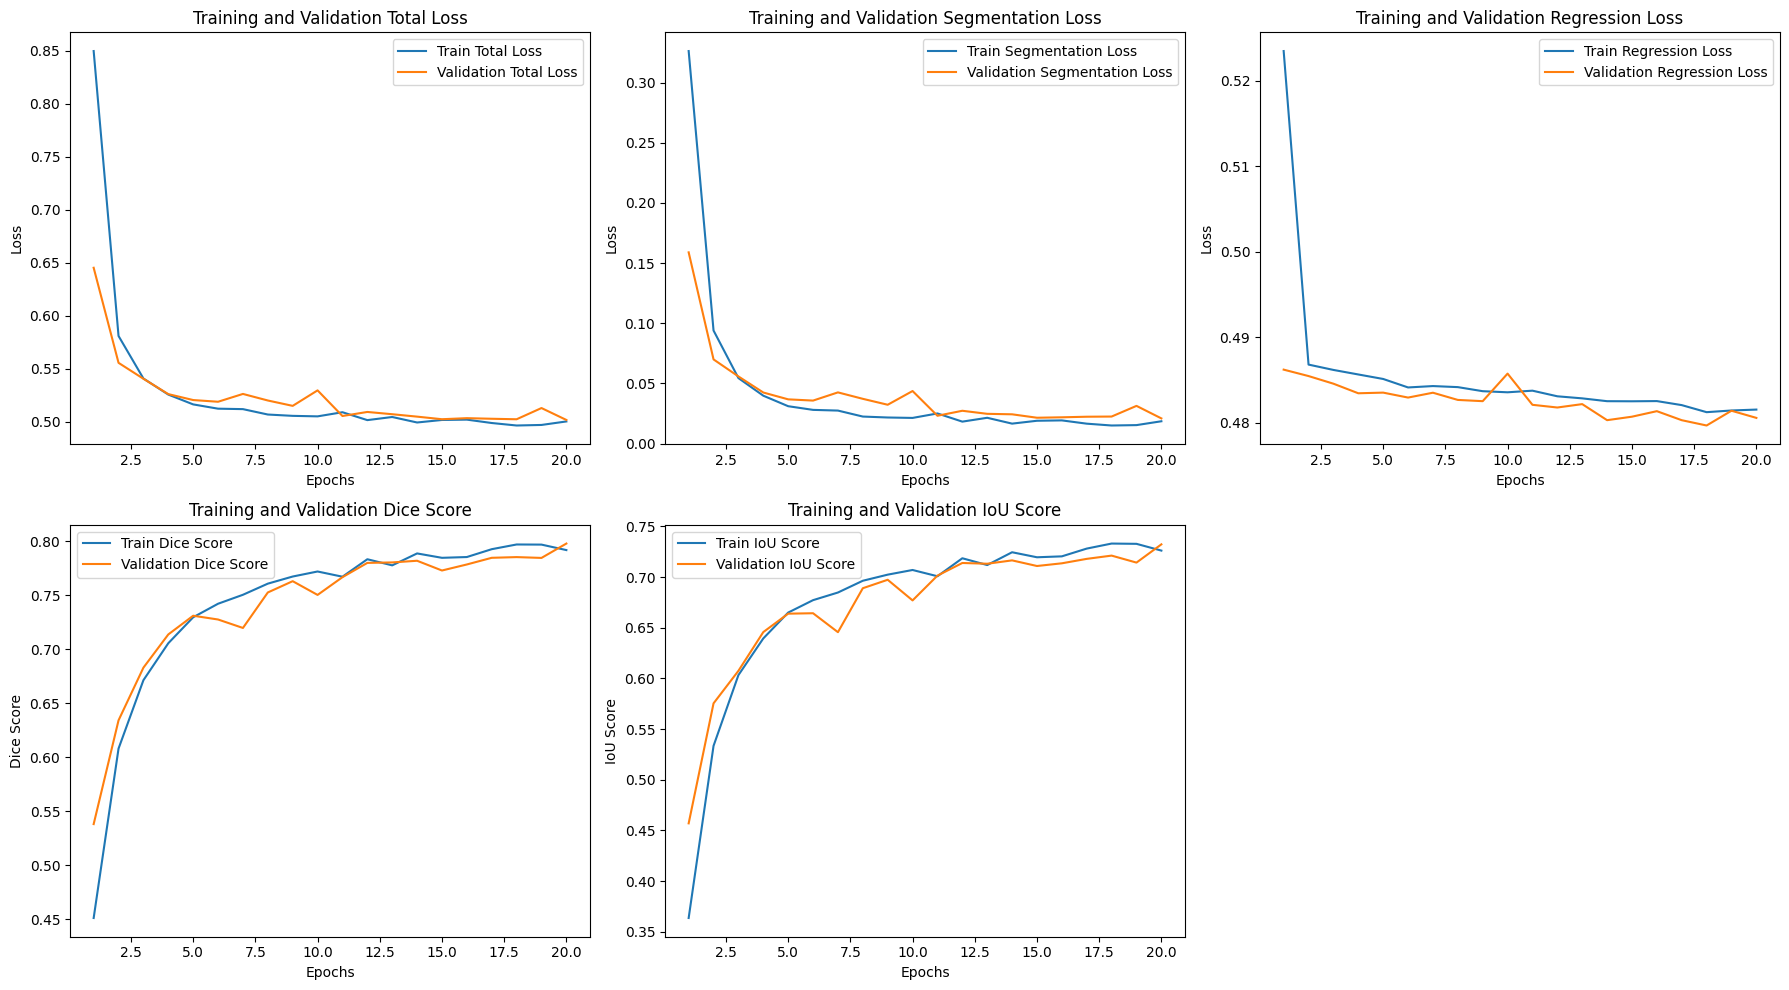

In [8]:
# Cell 8: Plotting Metrics

def plot_metrics(history_dict):
    epochs_range = range(1, len(history_dict['train_loss']) + 1)

    plt.figure(figsize=(18, 10))

    # Plot Total Loss
    plt.subplot(2, 3, 1)
    plt.plot(epochs_range, history_dict['train_loss'], label='Train Total Loss')
    plt.plot(epochs_range, history_dict['val_loss'], label='Validation Total Loss')
    plt.legend(loc='best')
    plt.title('Training and Validation Total Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    # Plot Segmentation Loss
    plt.subplot(2, 3, 2)
    plt.plot(epochs_range, history_dict['train_seg_loss'], label='Train Segmentation Loss')
    plt.plot(epochs_range, history_dict['val_seg_loss'], label='Validation Segmentation Loss')
    plt.legend(loc='best')
    plt.title('Training and Validation Segmentation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    if CONFIG["MULTITASK"] and history_dict.get('train_reg_loss'): # Check if reg loss exists
        # Plot Regression Loss
        plt.subplot(2, 3, 3)
        plt.plot(epochs_range, history_dict['train_reg_loss'], label='Train Regression Loss')
        plt.plot(epochs_range, history_dict['val_reg_loss'], label='Validation Regression Loss')
        plt.legend(loc='best')
        plt.title('Training and Validation Regression Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')

    # Plot Dice Score
    plt.subplot(2, 3, 4)
    plt.plot(epochs_range, history_dict['train_dice'], label='Train Dice Score')
    plt.plot(epochs_range, history_dict['val_dice'], label='Validation Dice Score')
    plt.legend(loc='best')
    plt.title('Training and Validation Dice Score')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Score')
    
    # Plot IoU Score
    plt.subplot(2, 3, 5)
    plt.plot(epochs_range, history_dict['train_iou'], label='Train IoU Score')
    plt.plot(epochs_range, history_dict['val_iou'], label='Validation IoU Score')
    plt.legend(loc='best')
    plt.title('Training and Validation IoU Score')
    plt.xlabel('Epochs')
    plt.ylabel('IoU Score')

    plt.tight_layout()
    plt.show()

# Make sure history is populated from training before calling this
if history['train_loss']: # Check if training actually ran
    plot_metrics(history)
else:
    print("No training history to plot. Run the training loop first.")

In [9]:
# Cell 9: Evaluation on Test Set (Corrected for empty loader)

def evaluate_model(model, loader):
    model.eval()
    total_loss = 0
    total_seg_loss = 0
    total_reg_loss = 0
    total_dice = 0
    total_iou = 0
    
    num_batches = len(loader)
    if num_batches == 0:
        print("Warning: Test DataLoader is empty. Evaluation cannot proceed. Returning zero metrics.")
        return 0.0, 0.0, 0.0, 0.0, 0.0

    print("\nEvaluating on Test Set...")
    progress_bar = tqdm(loader, desc="Test Evaluation", leave=False)

    with torch.no_grad():
        for batch_idx, data_batch in enumerate(progress_bar):
            if CONFIG["MULTITASK"]:
                images, masks, coords = data_batch
                images, masks, coords = images.to(CONFIG["DEVICE"]), masks.to(CONFIG["DEVICE"]), coords.to(CONFIG["DEVICE"])
                
                seg_preds, reg_preds = model(images)
                loss_seg = criterion_segmentation(seg_preds, masks)
                loss_reg = criterion_regression(reg_preds, coords)
                loss = loss_seg + loss_reg
                total_reg_loss += loss_reg.item()
            else:
                images, masks = data_batch
                images, masks = images.to(CONFIG["DEVICE"]), masks.to(CONFIG["DEVICE"])
                
                seg_preds = model(images)
                loss_seg = criterion_segmentation(seg_preds, masks)
                loss = loss_seg

            total_loss += loss.item()
            total_seg_loss += loss_seg.item()
            
            dice = dice_score(seg_preds, masks)
            iou = iou_score(seg_preds, masks)
            total_dice += dice.item()
            total_iou += iou.item()
            
            progress_bar.set_postfix(
                loss=total_loss/(batch_idx+1),
                dice=total_dice/(batch_idx+1),
                iou=total_iou/(batch_idx+1)
            )

    avg_loss = total_loss / num_batches
    avg_seg_loss = total_seg_loss / num_batches
    avg_reg_loss = total_reg_loss / num_batches if CONFIG["MULTITASK"] else 0
    avg_dice = total_dice / num_batches
    avg_iou = total_iou / num_batches

    print(f"\nTest Set Results:")
    print(f"  Average Total Loss: {avg_loss:.4f}")
    print(f"  Average Segmentation Loss: {avg_seg_loss:.4f}")
    if CONFIG["MULTITASK"]:
        print(f"  Average Regression Loss: {avg_reg_loss:.4f}")
    print(f"  Average Dice Score: {avg_dice:.4f}")
    print(f"  Average IoU Score: {avg_iou:.4f}")
    
    return avg_loss, avg_seg_loss, avg_reg_loss, avg_dice, avg_iou

# Load the best model for evaluation
best_model_path = os.path.join(CONFIG["CHECKPOINT_DIR"], "best_model.pth")
if os.path.exists(best_model_path):
    print(f"Loading best model from: {best_model_path}")
    checkpoint = torch.load(best_model_path, map_location=CONFIG["DEVICE"])
    
    eval_model = UNet(n_channels_in=1, 
                      n_classes_seg=CONFIG["NUM_CLASSES_SEG"], 
                      n_regression_targets=CONFIG["NUM_REGRESSION_TARGETS"] if CONFIG["MULTITASK"] else 0, 
                      multitask=CONFIG["MULTITASK"]).to(CONFIG["DEVICE"])
    eval_model.load_state_dict(checkpoint['model_state_dict'])
    
    if test_loader and len(test_loader.dataset) > 0 : 
        if len(test_loader) > 0 : # Also check if loader itself is not empty
             evaluate_model(eval_model, test_loader)
        else:
            print("Test DataLoader is empty (e.g. batch size > dataset size with drop_last=True). Skipping evaluation.")
    else:
        print("Test dataset is empty. Skipping evaluation.")
else:
    print("Best model checkpoint not found. Run training to generate it or evaluate a specific epoch's model.")

Loading best model from: checkpoints_nir_unet\best_model.pth

Evaluating on Test Set...



Test Set Results:
  Average Total Loss: 0.4902
  Average Segmentation Loss: 0.0177
  Average Regression Loss: 0.4725
  Average Dice Score: 0.8015
  Average IoU Score: 0.7364



Visualizing 3 predictions...


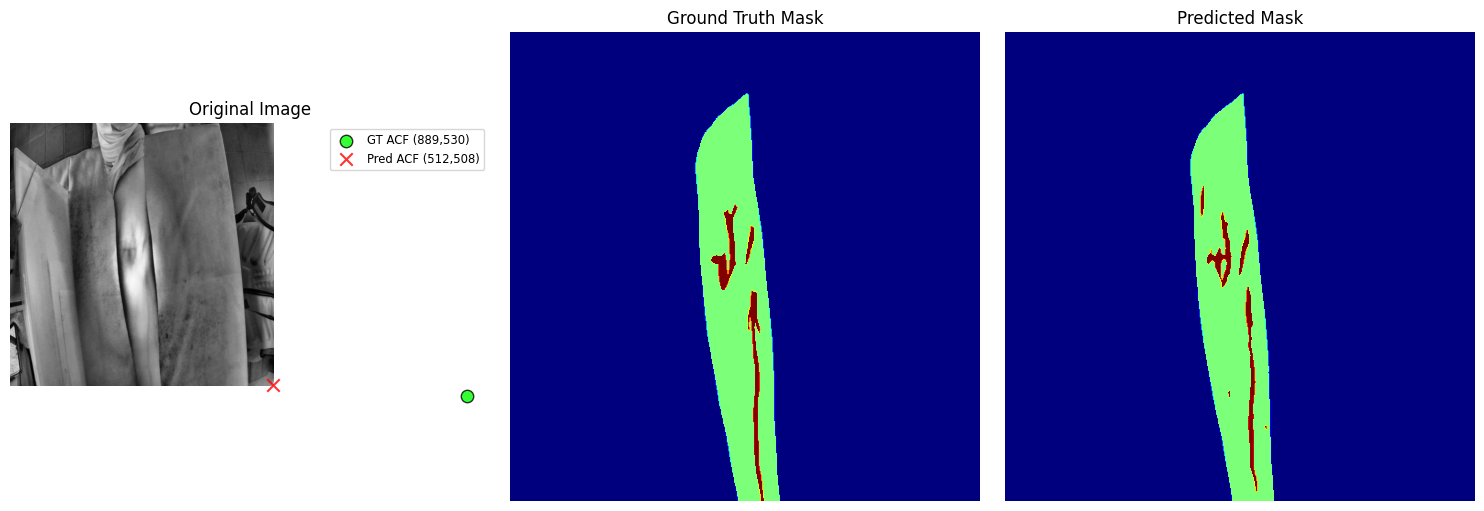

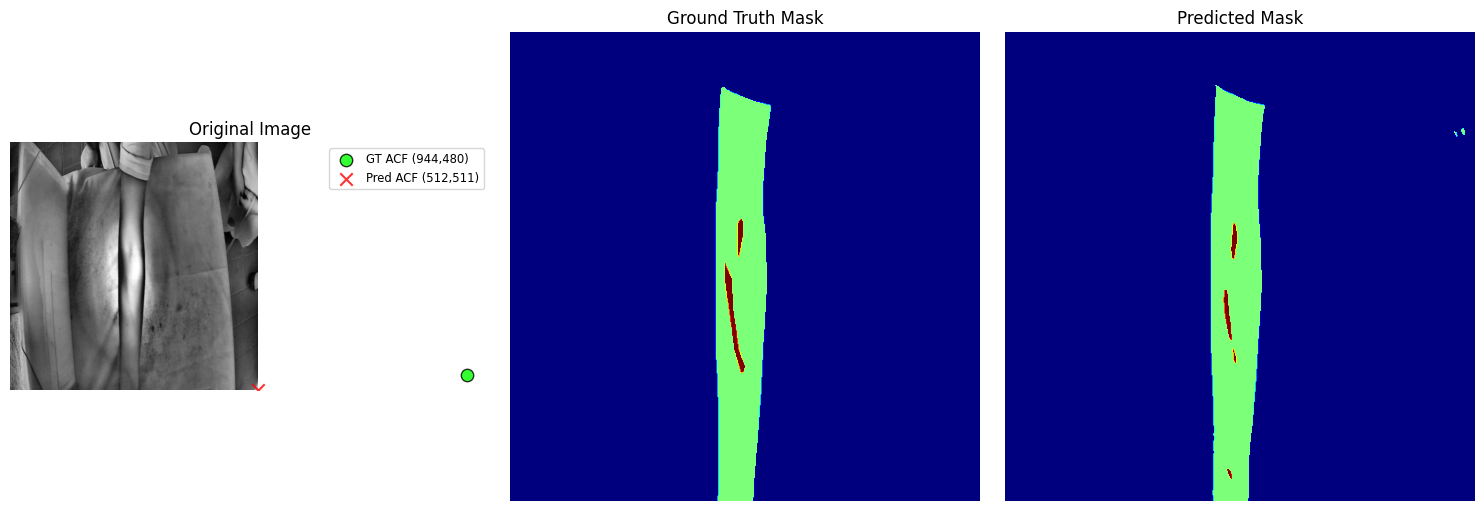

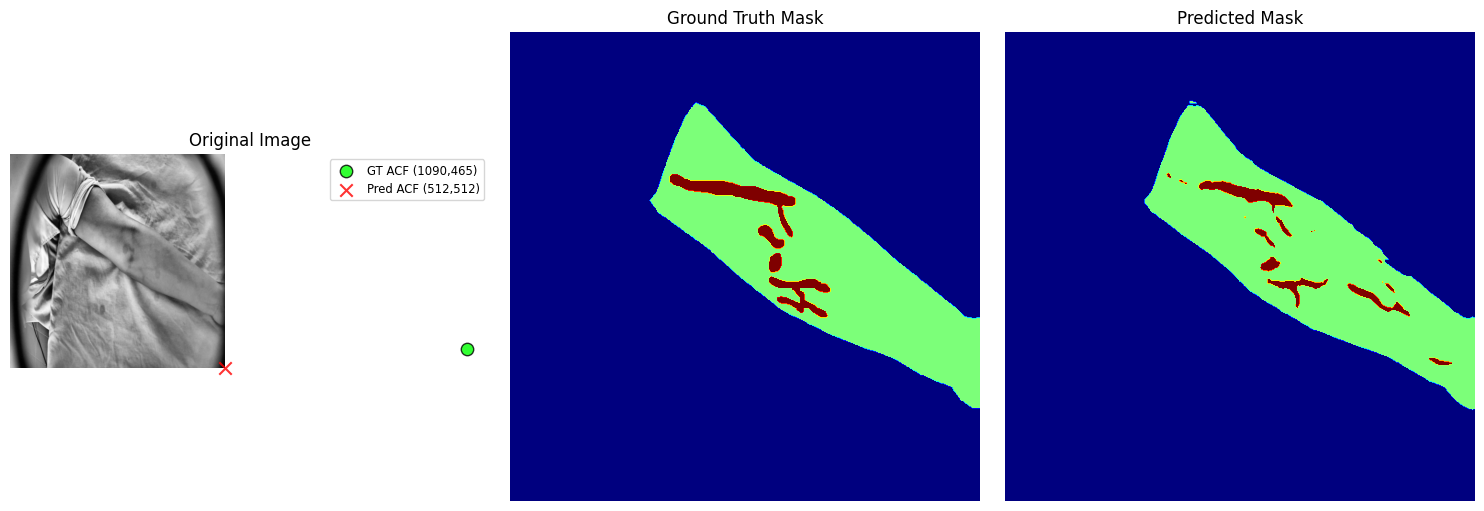

In [10]:
# Cell 10: Prediction & Visualization

def predict_and_visualize(model, dataset, num_samples=5):
    model.eval()
    
    if len(dataset) == 0:
        print("Dataset is empty, cannot visualize predictions.")
        return

    # Ensure num_samples does not exceed dataset size
    num_samples = min(num_samples, len(dataset))
    if num_samples == 0:
        print("No samples to visualize.")
        return

    print(f"\nVisualizing {num_samples} predictions...")
    
    # Get random samples
    sample_indices = random.sample(range(len(dataset)), num_samples)
    
    for i in sample_indices:
        if CONFIG["MULTITASK"]:
            image, gt_mask, gt_coords = dataset[i]
        else:
            image, gt_mask = dataset[i]
            gt_coords = None # Ensure gt_coords is defined

        # Prepare image for model (add batch dimension and move to device)
        image_batch = image.unsqueeze(0).to(CONFIG["DEVICE"])

        with torch.no_grad():
            if CONFIG["MULTITASK"]:
                pred_seg_logits, pred_coords_norm = model(image_batch)
            else:
                pred_seg_logits = model(image_batch)
                pred_coords_norm = None

        # Process segmentation prediction
        pred_mask_probs = torch.softmax(pred_seg_logits, dim=1)
        pred_mask = torch.argmax(pred_mask_probs, dim=1).squeeze(0).cpu().numpy()

        # Denormalize original image for display
        img_display = (image.cpu().squeeze().numpy() * 0.5) + 0.5
        gt_mask_display = gt_mask.cpu().squeeze().numpy()

        plt.figure(figsize=(15, 5))
        
        # Original Image (with GT and Pred Coords if multitask)
        plt.subplot(1, 3, 1)
        plt.imshow(img_display, cmap='gray')
        plt.title("Original Image")
        img_h, img_w = CONFIG["IMAGE_SIZE"]
        if CONFIG["MULTITASK"]:
            if gt_coords is not None: # Ground truth coordinates
                gt_x_denorm = gt_coords[0].item() * img_w
                gt_y_denorm = gt_coords[1].item() * img_h
                plt.scatter([gt_x_denorm], [gt_y_denorm], c='lime', marker='o', s=80, label=f'GT ACF ({gt_x_denorm:.0f},{gt_y_denorm:.0f})', alpha=0.8, edgecolors='black')
            if pred_coords_norm is not None: # Predicted coordinates
                pred_coords_norm_cpu = pred_coords_norm.squeeze(0).cpu()
                pred_x_denorm = pred_coords_norm_cpu[0].item() * img_w
                pred_y_denorm = pred_coords_norm_cpu[1].item() * img_h
                plt.scatter([pred_x_denorm], [pred_y_denorm], c='red', marker='x', s=80, label=f'Pred ACF ({pred_x_denorm:.0f},{pred_y_denorm:.0f})', alpha=0.8)
            plt.legend(fontsize='small')
        plt.axis('off')

        # Ground Truth Mask
        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask_display, cmap='jet', vmin=0, vmax=CONFIG["NUM_CLASSES_SEG"]-1)
        plt.title("Ground Truth Mask")
        plt.axis('off')

        # Predicted Mask
        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask, cmap='jet', vmin=0, vmax=CONFIG["NUM_CLASSES_SEG"]-1)
        plt.title("Predicted Mask")
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()

# Load the best model for visualization
# Ensure eval_model is defined from Cell 9 or load it here again if Cell 9 wasn't run successfully.
if 'eval_model' in locals() and isinstance(eval_model, nn.Module):
    # Use test_dataset for visualization
    predict_and_visualize(eval_model, test_dataset, num_samples=3)
elif os.path.exists(best_model_path):
    print(f"Loading best model from: {best_model_path} for visualization.")
    checkpoint = torch.load(best_model_path, map_location=CONFIG["DEVICE"])
    vis_model = UNet(n_channels_in=1, 
                     n_classes_seg=CONFIG["NUM_CLASSES_SEG"], 
                     n_regression_targets=CONFIG["NUM_REGRESSION_TARGETS"] if CONFIG["MULTITASK"] else 0, 
                     multitask=CONFIG["MULTITASK"]).to(CONFIG["DEVICE"])
    vis_model.load_state_dict(checkpoint['model_state_dict'])
    predict_and_visualize(vis_model, test_dataset, num_samples=3)
else:
    print("No trained model available for visualization. Please train a model first.")

